Step 7: Optimization with uncertain conversion rates, 𝛼 ratios, and number of items sold per product considering context generation

In [1]:
#fixed graph weights (same click influence probabilities between the products for each user)
#homogeneous users (one class with small variability)
#uncertain alphas
#uncertain number of items sold per product
#uncertain conversion rates
#three user classes

In [40]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from Environment.E_commerce import *
from Environment.Product import *
from Algorithms.Conv_rates_Learner import *
from Algorithms.TS_Learner_poisson import *
from Algorithms.CG_Learner_Environment import *
from Algorithms.UCB_Learner import *
from Algorithms.Greedy_Learner import *
from Algorithms.CG_UCB_Learner import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
P1 = Product(0,[9,12,13,14.5],[ 1.,  4,  5., 6.5])
P2 = Product(1,[20,22.5,23,24.5],[ 4.,  6.5, 7., 8.5])
P3 = Product(2,[30,31.5,34,34.5],[ 6.,  7.5, 10., 10.5])
P4 = Product(3,[40,42.5,43,46.5],[ 8., 10.5, 11., 14.5])
P5 = Product(4,[50,51.5,53,54.5],[10., 11.5, 13., 14.5])

products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
expected_units_sold_per_product = np.array([2,1,3,3,1]) #theese are the lambdas defined in the visit function
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
E = CG_E_commerce()
E.set_lambda(0.5)
for f1 in range(2):
    for f2 in range(2):
        E.set_products(f1,f2,products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

In [43]:
#Random algorithm which for each round pulls a random choice 
#to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
#useful for computing clairvoyant solution and regrets of the bandit algorithms


n_arms = 4
num_users = 100
n_days = 1000
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 3
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
conv_rates_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
mean_units_sold_per_product_per_eperiment = [[[] for _ in range(2)] for _ in range(2)]
cr_learner_expected_rewards_per_experiment = [[[] for _ in range(2)] for _ in range(2)]

for e in range(num_experiments):
    env = CG_Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
    for d in range(14):
        split1 = 1
        split2 = 0
        if split1==1 and split2==0:
            pulled_arm = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
            for f1 in range(2):
                for f2 in range(2):
                    pulled_arm[f1][f2] = cr_learners[f1].pull_arm()

            reward = env.round(pulled_arm)

            for f1 in range(2):
                cr_learners[f1].update(pulled_arm[f1][0], (reward[f1][0]+reward[f1][1]), (env.clicks_current_day[f1][0]+env.clicks_current_day[f1][1]), (env.purchases_current_day[f1][0]+env.purchases_current_day[f1][1]),(env.daily_units[f1][0]+env.daily_units[f1][1]))

    # FIRST DECISION
    P = env.E.users_by_class/np.sum(env.E.users_by_class)
    p_c1 = P[0][0] + P[0][1]
    p_c2 = P[1][0] + P[1][1]
    mu_c1 = np.sum(cr_learners[0].expected_rewards)
    mu_c2 = np.sum(cr_learners[1].expected_rewards)
    mu_c0 = 0 # TO BE DEFINED (we don't know how to learn it yet)

    # we consider the second split
    split2 = 1
    if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0:
        cr_learners = [[Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)] for _ in range(2)]
        split1 = 1
    else:
        cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
        split1 = 0

    for d in range(14):
        if split1==1 and split2==1:
            pulled_arm = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
            for f1 in range(2):
                for f2 in range(2):
                    pulled_arm[f1][f2] = cr_learners[f1][f2].pull_arm()

            reward = env.round(pulled_arm)

            for f1 in range(2):
                for f2 in range(2):
                    cr_learners[f1][f2].update(pulled_arm[f1][f2], reward[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])

        else: # split1 == 0 and split2 ==1
            pulled_arm = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
            for f1 in range(2):
                for f2 in range(2):
                    pulled_arm[f1][f2] = cr_learners[f2].pull_arm()

            reward = env.round(pulled_arm)

            for f2 in range(2):
                cr_learners[f2].update(pulled_arm[0][f2], (reward[0][f2]+reward[1][f2]), (env.clicks_current_day[0][f2]+env.clicks_current_day[1][f2]), (env.purchases_current_day[0][f2]+env.purchases_current_day[1][f2]),(env.daily_units[0][f2]+env.daily_units[1][f2]))

    # SECOND DECISION



    ## --> da qua in poi non siamo sicuri
    conversion_rates = [[np.zeros((5,4)) for _ in range(2)] for _ in range(2)]
    np.set_printoptions(suppress=True)

    for f1 in range(2):
        for f2 in range(2):
            for i in range(5):
                conversion_rates[f1][f2][i] = cr_learners[f1].beta_parameters[i][:,0]/(cr_learners[f1].beta_parameters[i][:,0]+cr_learners[f1].beta_parameters[i][:,1])
                opt_vector[f1][f2][e] += np.max(np.array(E.products[f1][f2][i].margins_list) * conversion_rates[f1][f2][i] * cr_learners[f1].lambda_poisson[i])
            conv_rates_per_experiment[f1][f2].append(conversion_rates[f1][f2])

    for f1 in range(2):
        for f2 in range(2):
            mean_units_sold_per_product_per_eperiment[f1][f2].append(cr_learners[f1].lambda_poisson)
            cr_learner_expected_rewards_per_experiment[f1][f2].append(cr_learners[f1].expected_rewards)

#optimal expected clarvoyant solution is given chosing each round the best combination
opt = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = [[np.zeros(5) for _ in range(2)] for _ in range(2)]


for f1 in range(2):
    for f2 in range(2):
        for i in range(5):
            best_arm_per_product[f1][f2][i] = np.argmax(np.array(E.products[f1][f2][i].margins_list) * np.mean(conv_rates_per_experiment[f1][f2],axis=0)[i]
                                                * np.mean(mean_units_sold_per_product_per_eperiment[f1][f2], axis = 0)[i])#expected_units_sold_per_product[i])#

print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected rewards per arm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_eperiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt) # optimal configuration: the best combination of arms


[[840, 0], [1053, 844]]
[[1243, 0], [1588, 1238]]
[[1674, 0], [2175, 1626]]
[[[array([[0.5       , 0.11111111, 0.36363636, 0.23728814],
       [0.51428571, 0.33333333, 0.18181818, 0.28571429],
       [0.5       , 0.66666667, 0.28571429, 0.15384615],
       [0.26666667, 0.02857143, 0.18918919, 0.14285714],
       [0.22857143, 0.3968254 , 0.25      , 0.41666667]]), array([[0.21428571, 0.92307692, 0.5       , 0.08163265],
       [0.15789474, 0.18181818, 0.33333333, 0.15151515],
       [0.28571429, 0.5       , 0.16666667, 0.25      ],
       [0.30769231, 0.18181818, 0.26666667, 0.15853659],
       [0.33333333, 0.30769231, 0.55      , 0.21568627]]), array([[0.25490196, 0.49315068, 0.2       , 0.25      ],
       [0.36842105, 0.5       , 0.75      , 0.09090909],
       [0.16      , 0.36363636, 0.66666667, 0.07692308],
       [0.33333333, 0.63636364, 0.20689655, 0.5       ],
       [0.5       , 0.6       , 0.2       , 0.27906977]])], [array([[0.5       , 0.11111111, 0.36363636, 0.23728814],
 

Abbiamo implementato CG LEARNER ENVIRONMENT, PER I LEARNERS usiamo una lista di learners.
RESTA DA IMPLEMENTARE:
1. ARE_WE SPLITTING basandoci su p*mu
2. MODIFICA_CONV_RATES
3. FINIRE CICLI FOR VARI E CONTROLLARE COME SONO MODIFICATI I beta_parameters
4. CONFRONT TS E UCB


In [39]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.plot(np.cumsum(np.mean(opt - gr_rewards_per_experiment, axis=0)), 'g')
plt.legend(["TS","UCB","Greedy"])
plt.show()

[[[array([[1.59166667, 1.125     , 2.        , 0.        ],
          [1.        , 0.        , 1.        , 1.        ],
          [2.6       , 2.96785714, 2.        , 2.4       ],
          [0.        , 2.75      , 3.        , 3.72      ],
          [1.        , 1.        , 1.        , 1.        ]]),
   array([[2.66666667, 2.        , 2.        , 0.        ],
          [1.        , 1.        , 0.        , 1.        ],
          [2.        , 4.23333333, 0.        , 0.        ],
          [2.        , 3.48611111, 3.        , 3.41666667],
          [1.        , 1.        , 1.        , 1.        ]]),
   array([[3.5       , 0.        , 3.07638889, 1.        ],
          [0.        , 1.        , 1.        , 1.        ],
          [4.        , 3.16666667, 4.25      , 2.75      ],
          [3.        , 0.        , 3.33333333, 3.11111111],
          [1.        , 1.        , 0.        , 1.        ]])],
  [array([[1.59166667, 1.125     , 2.        , 0.        ],
          [1.        , 0.        

In [37]:
#print(conv_rates_per_experiment[1][1])
print(conv_rates_per_experiment[1][1])
print(np.mean(conv_rates_per_experiment,axis=0)[1][1])

[[0.48245614 0.33071038 0.27413793 0.55288462]
 [0.3501171  0.61214087 0.39954163 0.40205628]
 [0.40668081 0.68026316 0.53703704 0.73209877]
 [0.35684211 0.42787524 0.62793963 0.31971154]
 [0.30700779 0.35995904 0.14459459 0.44047619]]


In [9]:
print("_______________________________________________")
print("TS Total collected reward")
print(np.sum(np.mean(ts_rewards_per_experiment,axis=0)))
print("UCB Total collected reward")
print(np.sum(np.mean(ucb_rewards_per_experiment,axis=0)))
print("_______________________________________________")

print("Considering all the experiments:")
print("-----------------------------------------------")
print("Total expected reward over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print("TS",np.mean(np.sum(ts_rewards_per_experiment, axis=1)),np.std(np.sum(ts_rewards_per_experiment, axis = 1)))
print("UCB",np.mean(np.sum(ucb_rewards_per_experiment, axis=1)),np.std(np.sum(ucb_rewards_per_experiment, axis = 1)))
print("-----------------------------------------------")
print("Total expected regret over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print("TS",np.mean(np.sum(opt - ts_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ts_rewards_per_experiment, axis=1)))
print("UCB",np.mean(np.sum(opt - ucb_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ucb_rewards_per_experiment, axis=1)))

print("-----------------------------------------------")
print("Average expected reward per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print("TS",np.mean(np.mean(ts_rewards_per_experiment, axis=0)), np.std(np.mean(ts_rewards_per_experiment, axis=0)))
print("UCB",np.mean(np.mean(ucb_rewards_per_experiment, axis=0)), np.std(np.mean(ucb_rewards_per_experiment, axis=0)))
print("-----------------------------------------------")
print("Average expected regret per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print("TS",np.mean(np.mean(opt-ts_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ts_rewards_per_experiment, axis=0)))
print("UCB",np.mean(np.mean(opt-ucb_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ucb_rewards_per_experiment, axis=0)))

_______________________________________________
TS Total collected reward
47238.07200937951
UCB Total collected reward
47491.82153138528
_______________________________________________
Considering all the experiments:
-----------------------------------------------
Total expected reward over 1000 days and its standard deviation considering 10 experiments
TS 47238.07200937951 826.054348203146
UCB 47491.821531385285 564.8743380720076
-----------------------------------------------
Total expected regret over 1000 days and its standard deviation considering 10 experiments
TS 1754.6259873896295 826.0543482031461
UCB 1500.8764653838573 564.8743380720067
-----------------------------------------------
Average expected reward per round over 1000 days and its standard deviation between the rounds considering 10 experiments
TS 47.23807200937951 3.351133726908961
UCB 47.49182153138528 3.342032906479586
-----------------------------------------------
Average expected regret per round over 1000 day

In [10]:
print("TS Pulls per arm")
for i in range(len(ts_pulls_per_arm_per_experiment)):
    print("_______________________________________________")
    print(ts_pulls_per_arm_per_experiment[i])

TS Pulls per arm
_______________________________________________
[[  1. 793.   1. 205.]
 [ 66. 749. 147.  38.]
 [965.   3.   1.  31.]
 [  2. 969.  28.   1.]
 [880. 103.   8.   9.]]
_______________________________________________
[[  1. 110. 810.  79.]
 [  5. 673. 227.  95.]
 [705.  74. 215.   6.]
 [925.  38.  36.   1.]
 [682. 295.   9.  14.]]
_______________________________________________
[[  1.  95. 903.   1.]
 [ 27. 706. 222.  45.]
 [919.   1.   3.  77.]
 [  3. 935.  51.  11.]
 [846. 110.  20.  24.]]
_______________________________________________
[[  1.   5. 729. 265.]
 [ 14. 717. 226.  43.]
 [  4. 918.  68.  10.]
 [969.   1.  29.   1.]
 [866. 124.   9.   1.]]
_______________________________________________
[[  1.  88. 852.  59.]
 [ 22. 309. 621.  48.]
 [  4. 960.  35.   1.]
 [939.  42.  12.   7.]
 [904.  36.  51.   9.]]
_______________________________________________
[[  1.  51. 765. 183.]
 [ 25. 853.  64.  58.]
 [776. 133.  76.  15.]
 [709. 267.   4.  20.]
 [773. 199.  18.  10.]]

In [11]:
print("UCB Pulls per arm")
for i in range(len(ucb_pulls_per_arm_per_experiment)):
    print("_______________________________________________")
    print(ucb_pulls_per_arm_per_experiment[i])

UCB Pulls per arm
_______________________________________________
[[ 11. 277. 256. 456.]
 [ 21.   2. 956.  21.]
 [374. 567.  57.   2.]
 [  2. 734. 262.   2.]
 [843. 138.  17.   2.]]
_______________________________________________
[[  2. 190. 775.  33.]
 [ 28.   2. 958.  12.]
 [699. 256.  43.   2.]
 [967.  27.   4.   2.]
 [966.  26.   6.   2.]]
_______________________________________________
[[  2. 832.   4. 162.]
 [  8. 988.   2.   2.]
 [  2. 993.   3.   2.]
 [972.  24.   2.   2.]
 [961.  35.   2.   2.]]
_______________________________________________
[[  2. 269. 566. 163.]
 [118. 864.  15.   3.]
 [449. 504.  45.   2.]
 [979.  15.   4.   2.]
 [988.   8.   2.   2.]]
_______________________________________________
[[  2. 204. 654. 140.]
 [  2.  41. 949.   8.]
 [  5. 978.  10.   7.]
 [942.  45.   6.   7.]
 [994.   2.   2.   2.]]
_______________________________________________
[[  2. 318. 363. 317.]
 [ 84. 795. 101.  20.]
 [416. 511.  63.  10.]
 [882.  97.  19.   2.]
 [  2. 988.   2.   8.]

In [12]:
# Not always find the best solution
#[994.   2.   2.   2.]
#[186. 778.  34.   2.]
#[  2.   2. 981.  15.] ------ doesn't found the optimal price (1)
#[994.   2.   2.   2.]
#[282. 713.   3.   2.]]
# Happens also with TS

In [13]:
#Comparison between TS and UCB with respect to the number of users per round

n_arms = 4
num_users = 10
n_days = 1000
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ts_rewards_per_experiment_10 = []
ucb_rewards_per_experiment_10 = []

ts_rewards_per_experiment_100 = []
ucb_rewards_per_experiment_100 = []


ts_rewards_per_experiment_1000 = []
ucb_rewards_per_experiment_1000 = []


for e in range(n_experiments):

    env_10 = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner_10 = UCB(n_arms=n_arms)
    ts_learner_10 = TS_poisson(n_arms=n_arms)

    env_100 = Environment(n_arms, E, margins_matrix, num_users*10, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner_100 = UCB(n_arms=n_arms)
    ts_learner_100 = TS_poisson(n_arms=n_arms)

    env_1000 = Environment(n_arms, E, margins_matrix, num_users*100, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner_1000 = UCB(n_arms=n_arms)
    ts_learner_1000 = TS_poisson(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = ucb_learner_10.pull_arm()
        reward = env_10.round(pulled_arm)
        ucb_learner_10.update(pulled_arm, reward)

        pulled_arm = ucb_learner_100.pull_arm()
        reward = env_100.round(pulled_arm)
        ucb_learner_100.update(pulled_arm, reward)

        pulled_arm = ucb_learner_1000.pull_arm()
        reward = env_1000.round(pulled_arm)
        ucb_learner_1000.update(pulled_arm, reward)
        
        pulled_arm = ts_learner_10.pull_arm(env_10.margins_matrix)
        reward = env_10.round(pulled_arm)
        ts_learner_10.update(pulled_arm, reward, env_10.clicks_current_day, env_10.purchases_current_day, env_10.daily_units)

        pulled_arm = ts_learner_100.pull_arm(env_100.margins_matrix)
        reward = env_100.round(pulled_arm)
        ts_learner_100.update(pulled_arm, reward, env_100.clicks_current_day, env_100.purchases_current_day,  env_100.daily_units)

        pulled_arm = ts_learner_1000.pull_arm(env_1000.margins_matrix)
        reward = env_1000.round(pulled_arm)
        ts_learner_1000.update(pulled_arm, reward, env_1000.clicks_current_day, env_1000.purchases_current_day,  env_1000.daily_units)

    ts_rewards_per_experiment_10.append(ts_learner_10.collected_rewards)
    ucb_rewards_per_experiment_10.append(ucb_learner_10.collected_rewards)

    
    ts_rewards_per_experiment_100.append(ts_learner_100.collected_rewards)
    ucb_rewards_per_experiment_100.append(ucb_learner_100.collected_rewards)

    
    ts_rewards_per_experiment_1000.append(ts_learner_1000.collected_rewards)
    ucb_rewards_per_experiment_1000.append(ucb_learner_1000.collected_rewards)


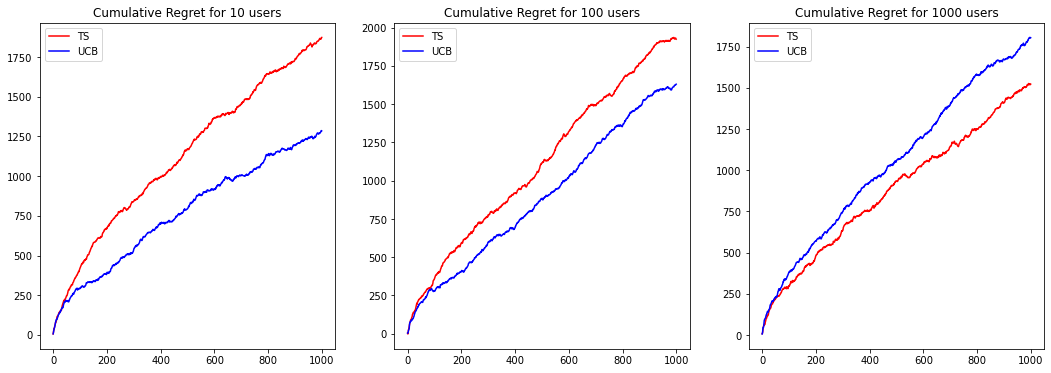

In [14]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18,6))
ax[0].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_10, axis=0)), 'r')
ax[0].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_10, axis=0)), 'b')
ax[0].set_title("Cumulative Regret for 10 users")
ax[0].legend(["TS","UCB"])

ax[1].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_100, axis=0)), 'r')
ax[1].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_100, axis=0)), 'b')
ax[1].set_title("Cumulative Regret for 100 users")
ax[1].legend(["TS","UCB"])

ax[2].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_1000, axis=0)), 'r')
ax[2].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_1000, axis=0)), 'b')
ax[2].set_title("Cumulative Regret for 1000 users")
ax[2].legend(["TS","UCB"])

plt.show()